# **Deep Learning - 96943**
# **Assignment - 3**
# **Abdul Haseeb - 17132**
# **Annayah Usman - 18673**

## **Importing Dependencies**

In [1]:
!pip install torchsummary

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils
import random
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
# Fixing seed for reproducibility

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **Data Preparation and Exploration**

In [4]:
# Downloading Data

# API Credentials
os.environ['KAGGLE_USERNAME'] = '###############################################'
os.environ['KAGGLE_KEY'] = '###############################################'

!kaggle competitions download -c dog-vs-cat-vs-bird
!unzip dog-vs-cat-vs-bird.zip -d ./dataset

base_dir = "./dataset/dataset"
train_images_dir = os.path.join(base_dir, "train")
test_images_dir = os.path.join(base_dir, "test")
train_csv_path = os.path.join(base_dir, "train.csv")
sample_submission_path = os.path.join(base_dir, "sample_submission.csv")

 89%|█████████████████████████████████▊    | 36.0M/40.4M [00:02<00:00, 20.2MB/s]
100%|██████████████████████████████████████| 40.4M/40.4M [00:02<00:00, 18.8MB/s]
Archive:  dog-vs-cat-vs-bird.zip
  inflating: ./dataset/dataset/sample_submission.csv  
  inflating: ./dataset/dataset/test/img_0.png  
  inflating: ./dataset/dataset/test/img_1.png  
  inflating: ./dataset/dataset/test/img_10.png  
  inflating: ./dataset/dataset/test/img_100.png  
  inflating: ./dataset/dataset/test/img_1000.png  
  inflating: ./dataset/dataset/test/img_1001.png  
  inflating: ./dataset/dataset/test/img_1002.png  
  inflating: ./dataset/dataset/test/img_1003.png  
  inflating: ./dataset/dataset/test/img_1004.png  
  inflating: ./dataset/dataset/test/img_1005.png  
  inflating: ./dataset/dataset/test/img_1006.png  
  inflating: ./dataset/dataset/test/img_1007.png  
  inflating: ./dataset/dataset/test/img_1008.png  
  inflating: ./dataset/dataset/test/img_1009.png  
  inflating: ./dataset/dataset/test/img_101.p

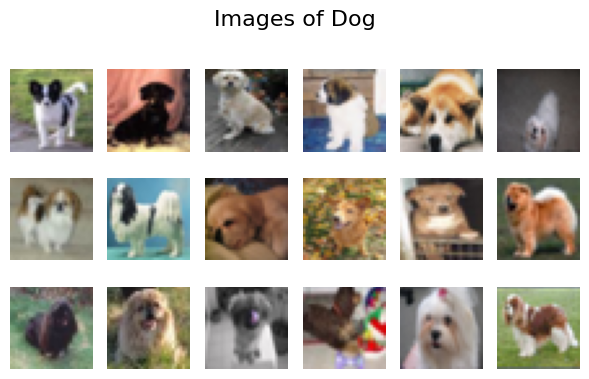

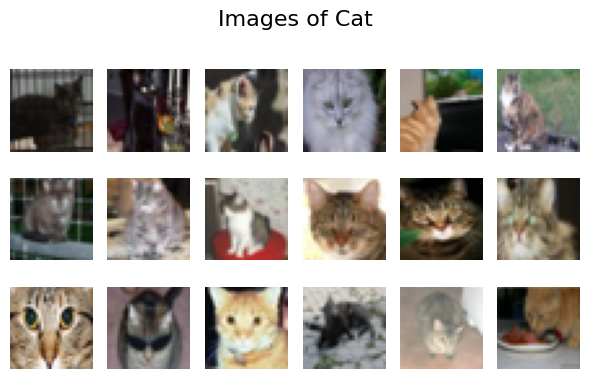

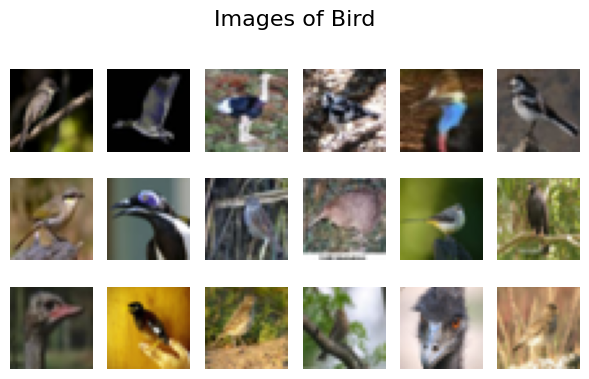

In [5]:
# Visualizing Data

train_df = pd.read_csv(train_csv_path)

def plot_image_grid(image_paths, label, nrows=3, ncols=6):
    fig, axes = plt.subplots(nrows, ncols, figsize=(6, 4))
    fig.suptitle(f"Images of {label.capitalize()}", fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(image_paths):
            img = Image.open(image_paths[i]).convert("RGB") 
            ax.imshow(img)
            ax.axis("off")
        else:
            ax.axis("off") 

    plt.tight_layout()
    plt.show()

for label in ["dog", "cat", "bird"]:
    label_filenames = train_df[train_df['label'] == label]['filename'].tolist()
    sampled_filenames = random.sample(label_filenames, 18)
    image_paths = [os.path.join(train_images_dir, fname) for fname in sampled_filenames]
    plot_image_grid(image_paths, label)
    if label!='bird':
        print("\n\n")

## **CNN**

In [6]:
# Defining  & computing mean pixel intensity and std for each channel for normalization

class TrainDataset(Dataset):
    def __init__(self, csv_file, img_dir, device, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.device = device
        self.transform = transform
        self.images = []  
        self.labels = []
        self.loaded = False 
        self.preload_to_gpu()

    def preload_to_gpu(self):
        if self.loaded:
            self.clear_memory()

        label_map = {"cat": 0, "dog": 1, "bird": 2}

        for idx in tqdm(range(len(self.data)), desc="Preloading Data"):
            img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
            label = label_map[self.data.iloc[idx, 1]]
            image = Image.open(img_name).convert("RGB")

            if self.transform:
                image = self.transform(image)

            self.images.append(image.to(self.device))
            self.labels.append(torch.tensor(label, device=self.device))

        self.loaded = True  # Mark data as loaded
        print(f"Data loaded: {len(self.images)} images and {len(self.labels)} labels.")

    def clear_memory(self):
        if not self.loaded:  
            return
        for img in self.images:
            del img
        for lbl in self.labels:
            del lbl

        self.images.clear()
        self.labels.clear()

        gc.collect()  
        torch.cuda.empty_cache()
        self.loaded = False 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if not self.loaded:
            raise ValueError("Data has not been loaded yet.") 
        return self.images[idx], self.labels[idx]

class TestDataset(Dataset):
    def __init__(self, img_dir, device, transform=None):
        self.img_dir = img_dir
        self.device = device
        self.transform = transform
        self.images = []  
        self.image_paths = []  
        self.loaded = False  
        self.preload_to_gpu()

    def preload_to_gpu(self):
        if self.loaded:
            self.clear_memory()

        self.image_paths = sorted(os.listdir(self.img_dir))

        for img_name in tqdm(self.image_paths, desc="Preloading Test Data"):
            img_path = os.path.join(self.img_dir, img_name)
            image = Image.open(img_path).convert("RGB")

            if self.transform:
                image = self.transform(image)

            self.images.append(image.to(self.device))

        self.loaded = True  # Mark data as loaded
        print(f"Test data loaded: {len(self.images)} images.")  

    def clear_memory(self):
        if not self.loaded:  
            return
        for img in self.images:
            del img

        self.images.clear()
        self.image_paths.clear()

        gc.collect() 
        torch.cuda.empty_cache() 
        self.loaded = False 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if not self.loaded:
            raise ValueError("Data has not been loaded yet.") 
        return self.images[idx], self.image_paths[idx]


labels = pd.read_csv(train_csv_path)['label']
train_indices, val_indices = train_test_split(
    list(range(len(labels))),
    test_size=0.15, 
    stratify=labels,
    random_state=0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tf = transforms.Compose([transforms.ToTensor()])

train_data = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=tf)
train_sub = Subset(train_data, train_indices)

def compute_mean_std(dataset, device):
    sum_pixels = torch.zeros(3, device=device) 
    sum_squared_pixels = torch.zeros(3, device=device)
    num_pixels = 0

    for idx in tqdm(range(len(dataset))):
        image, _ = dataset[idx]  

        sum_pixels += image.sum(dim=(1, 2))  
        sum_squared_pixels += (image ** 2).sum(dim=(1, 2))  
        num_pixels += image.shape[1] * image.shape[2] 

    mean = sum_pixels / num_pixels
    std = torch.sqrt(sum_squared_pixels / num_pixels - mean ** 2)

    return mean.cpu().numpy(), std.cpu().numpy()

mean, std = compute_mean_std(train_sub, device)
print(f"Training Set Mean: {mean}")
print(f"Training Set Std: {std}")

Preloading Data: 100%|██████████| 12000/12000 [00:07<00:00, 1560.25it/s]


Data loaded: 12000 images and 12000 labels.


100%|██████████| 10200/10200 [00:00<00:00, 15367.10it/s]


Training Set Mean: [0.4942871  0.47079718 0.4185342 ]
Training Set Std: [0.24545404 0.24013247 0.2502856 ]


In [7]:
# Loading Data w/ Augmentation & Splitting in Train & Validation (Stratified), & Test Set

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),                      # Resize images to 32x32
    transforms.RandomRotation(degrees=15),           # Randomly rotate images by up to ±15 degrees
    transforms.RandomHorizontalFlip(),               # Randomly flip images horizontally
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),  # Randomly zoom in on images
    transforms.RandomAffine(degrees=0, shear=10),    # Apply random shear transformations
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),  # Slight distortion for perspective
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5),  # Random color jitter
    transforms.ToTensor(),                           # Convert image to PyTorch tensor and scale to [0, 1]
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize using computed mean & std
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),                   # Resize images to 32x32
    transforms.ToTensor(),                         # Convert images to tensors (scale pixel values to [0, 1])
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize tensors
])

train_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=train_transform)
train_subset = Subset(train_dataset, train_indices)
val_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=test_transform)
val_subset = Subset(val_dataset, val_indices)
test_dataset = TestDataset(img_dir=test_images_dir, device=device, transform=test_transform)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Preloading Data: 100%|██████████| 12000/12000 [00:21<00:00, 566.01it/s]


Data loaded: 12000 images and 12000 labels.


Preloading Data: 100%|██████████| 12000/12000 [00:08<00:00, 1339.41it/s]


Data loaded: 12000 images and 12000 labels.


Preloading Test Data: 100%|██████████| 3000/3000 [00:01<00:00, 1660.08it/s]

Test data loaded: 3000 images.


In [8]:
# Hyperparameters

image_size=32
kernel_size=3
padding=1
stride=1
pooling=2
image_channel=3
num_conv_layers=4
num_filters1=32
num_filters2=64
num_filters3=128
num_filters4=256

fcnn_input=((((image_size+num_conv_layers*(2*padding-kernel_size+1))) // (pooling**4)) ** 2) * num_filters4
nhdn=512
classes=3

dropout_rate=0.20

learning_rate=0.001
l1_lambda=0.0001
clip_grad=1.0

In [9]:
# Model Architechture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(image_channel, num_filters1, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(num_filters1)
        self.pool1 = nn.MaxPool2d(pooling)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(num_filters2)
        self.pool2 = nn.MaxPool2d(pooling)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Conv Layer 3
        self.conv3 = nn.Conv2d(num_filters2, num_filters3, kernel_size=kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(num_filters3)
        self.pool3 = nn.MaxPool2d(pooling)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Conv Layer 4
        self.conv4 = nn.Conv2d(num_filters3, num_filters4, kernel_size=kernel_size, padding=padding)
        self.bn4 = nn.BatchNorm2d(num_filters4)
        self.pool4 = nn.MaxPool2d(pooling)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # Fully Connected layers
        self.fc1 = nn.Linear(fcnn_input, nhdn)
        self.bn5 = nn.BatchNorm1d(nhdn)
        self.dropout5 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc2 = nn.Linear(nhdn, classes)
        
    def forward(self, x):
        # Conv Layer 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Conv Layer 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Conv Layer 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Conv Layer 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout5(x)
        
        # Output layer (softmax is applied in the loss function)
        x = self.fc2(x)
        
        return x

In [10]:
def evaluate_model(model, val_loader, criterion, device):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()  # Switch the model to evaluation mode
    val_loss = 0
    correct = 0
    with torch.no_grad():  # No gradient tracking during evaluation
        for images, labels in val_loader:
            images, labels = images, labels
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / len(val_loader.dataset)
    return val_acc, val_loss

def train_model(
    model, optimizer, criterion, train_loader, test_loader,
    scheduler=None, epochs=10, show_output=True,
    l1_lambda=0.0, clip_grad_norm=None
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    best_model = None
    best_train_loss = float('inf')
    best_train_acc = 0
    best_val_loss = float('inf')
    best_val_acc = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0

        for images, labels in train_loader:
            images, labels = images, labels

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            if l1_lambda > 0:
                l1_loss = sum(param.abs().sum() for param in model.parameters())
                loss += l1_lambda * l1_loss

            loss.backward()

            if clip_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)

            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        val_acc, val_loss = evaluate_model(model, val_loader, criterion, device)

        if scheduler is not None:
            scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_train_loss = train_loss
            best_train_acc = train_acc
            best_model = model.state_dict()

        if show_output and epoch % 5 == 4:
            print(
                f"Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

    if show_output:
        epochs_range = range(1, len(train_losses) + 1)
        
        # Plot Loss
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_losses, label='Train Loss')
        plt.plot(epochs_range, val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
        plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    model.load_state_dict(best_model)
    return model, best_train_loss, best_train_acc, best_val_loss, best_val_acc

In [11]:
# Initialize Model

model = CNN().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
        MaxPool2d-11            [-1, 128, 4, 4]               0
          Dropout-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 256, 4, 4]         295,168
      BatchNorm2d-14            [-1, 25

In [12]:
# Weight Initialization

def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)
    elif isinstance(layer, torch.nn.BatchNorm2d):
        torch.nn.init.ones_(layer.weight)
        torch.nn.init.zeros_(layer.bias)

model.apply(initialize_weights)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, e

Epoch 5/50, Train Loss: 1.7296, Train Acc: 0.5719, Val Loss: 0.8435, Val Acc: 0.6111
Epoch 10/50, Train Loss: 1.4485, Train Acc: 0.6251, Val Loss: 0.7093, Val Acc: 0.6850
Epoch 15/50, Train Loss: 1.2721, Train Acc: 0.6665, Val Loss: 0.6937, Val Acc: 0.6939
Epoch 20/50, Train Loss: 1.1176, Train Acc: 0.6871, Val Loss: 0.6073, Val Acc: 0.7300
Epoch 25/50, Train Loss: 0.9560, Train Acc: 0.7358, Val Loss: 0.5762, Val Acc: 0.7561
Epoch 30/50, Train Loss: 0.8511, Train Acc: 0.7698, Val Loss: 0.5446, Val Acc: 0.7778
Epoch 35/50, Train Loss: 0.8004, Train Acc: 0.7893, Val Loss: 0.5393, Val Acc: 0.7806
Epoch 40/50, Train Loss: 0.7542, Train Acc: 0.8058, Val Loss: 0.5491, Val Acc: 0.7856
Epoch 45/50, Train Loss: 0.7399, Train Acc: 0.8118, Val Loss: 0.5558, Val Acc: 0.7839
Epoch 50/50, Train Loss: 0.7294, Train Acc: 0.8100, Val Loss: 0.5541, Val Acc: 0.7828


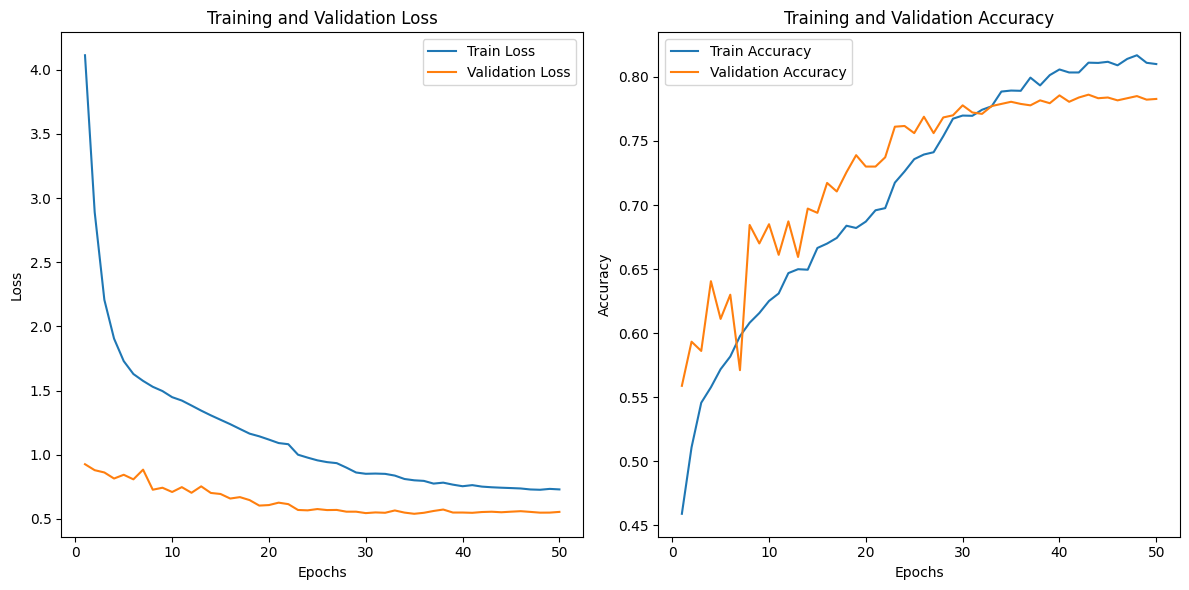

In [13]:
# Initialize criterion, optimizer, scheduler, and finally train.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=1e-5, verbose=1)

best_model, best_train_loss, best_train_acc, best_val_loss, best_val_acc = train_model(
    model, optimizer, criterion, train_loader, val_loader,
    scheduler=scheduler, epochs=50, show_output=True,
    l1_lambda=l1_lambda, clip_grad_norm=clip_grad
)

Optimized learning rate, learning rate scheduler, l1 regularization lambda, gradient clipping norm, and number of epochs required on the validation set.

Results from the best configuration are shown above. Different experimentations were performed with various configurations, but only the selected one is shown to reduce redundancy.

The following choices were explored:

- **Learning Rate:** (0.01, 0.001, 0.0001)
- **Min_lr:** (0.0001, 0.00001)
- **Learning Rate Scheduler:** (ReduceLROnPlateau, CosineAnnealingLR)
- **L1_lambda:** (0.001,0.0001,0.00001)
- **Clip_grad:** (0.5, 0.75, 0.9, 1.0, 2.0)
- **Epochs:** (20, 40, 50, 100)

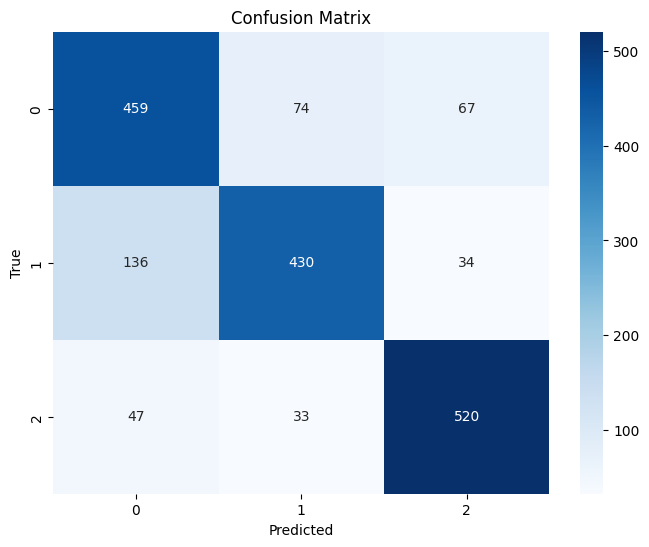

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       600
           1       0.80      0.72      0.76       600
           2       0.84      0.87      0.85       600

    accuracy                           0.78      1800
   macro avg       0.78      0.78      0.78      1800
weighted avg       0.78      0.78      0.78      1800



In [14]:
def evaluate_model_with_confusion_matrix(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Don't need gradients for validation
        for images, labels in val_loader:
            images, labels = images, labels
            
            outputs = model(images)
            
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())  

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    return cm


best_model = best_model.to(device)
cm = evaluate_model_with_confusion_matrix(best_model, val_loader, device)

In [15]:
# Save the best model's state dictionary
model_save_path = "best_cnn_model.pth"
torch.save(best_model.state_dict(), model_save_path)
print(f"Best model saved to {model_save_path}")

from IPython.display import FileLink
# Generate a download link for the model file
FileLink(model_save_path)

Best model saved to best_cnn_model.pth


/kaggle/working/best_cnn_model.pth

### **Test Set Predictions**

In [16]:
label_map = {"cat": 0, "dog": 1, "bird": 2}
reverse_label_map = {v: k for k, v in label_map.items()}  # {0: "cat", 1: "dog", 2: "bird"}

def predict_and_save_to_csv(model, test_loader, device, output_csv="submission.csv"):
    model.eval() 
    model = model.to(device)
    predictions = []
    
    with torch.no_grad(): 
        for images, filenames in tqdm(test_loader): 
            images = images
            outputs = model(images) 
            _, preds = torch.max(outputs, dim=1)
            for filename, pred in zip(filenames, preds):
                predictions.append({
                    "filename": filename, 
                    "label": reverse_label_map[pred.item()]  
                })

    df = pd.DataFrame(predictions)
    df = df.sort_values(by="filename", key=lambda col: col.str.extract(r'(\d+)').astype(int).squeeze()).reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    print(f"Submission saved to {output_csv}")

In [17]:
predict_and_save_to_csv(best_model, test_loader, device, output_csv="cnn_submission.csv")

100%|██████████| 94/94 [00:00<00:00, 634.63it/s]

Submission saved to cnn_submission.csv


In [18]:
from IPython.display import FileLink
# Generate a download link for the file
file_path = "cnn_submission.csv"
FileLink(file_path)

/kaggle/working/cnn_submission.csv

## **VGG-16**

In approach 1, VGG classifier is modified such that instead of mapping from 4096 units to 1000 units in final layer, another layer of 128 units is added instead of output of layer of 1000 units and finally an output of layer of 3 units is added at the end. So, 4096>1000 to 4096>128>3 where weights between 4096 to 128 to 3 units are trainable and rest are frozen.

In approach 1, the following choices were explored:

- **Learning Rate:** (0.001, 0.0001)
- **Min_lr:** (0.0001, 0.00001)

Again, only the selected configuration is shown to reduce redundancy. The best configuration of lr=0.001 and min_lr= 0.00001 was kept constant for approach 2 as well.

In approach 2, instead of modifying the existing classifier new layers are added in the classifier and all of pretrained weights are kept frozen from the original VGG and only the newly added parameters are learned. So, 4096>1000 to 4096>1000>128>3 where weights between 1000 to 128 to 3 units are trainable and rest are frozen.

Since approach 1 

**Approach 1**

In [5]:
# Defining  & computing mean pixel intensity and std for each channel for normalization

class TrainDataset(Dataset):
    def __init__(self, csv_file, img_dir, device, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.device = device
        self.transform = transform
        self.images = []  # No need to preload images, just store file paths
        self.labels = []  # Store labels
        self.label_map = {"cat": 0, "dog": 1, "bird": 2}
        
        for idx in range(len(self.data)):
            img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
            label = self.label_map[self.data.iloc[idx, 1]]
            self.images.append(img_name)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image.to(self.device)
        label = torch.tensor(label, device=self.device)

        return image, label

class TestDataset(Dataset):
    def __init__(self, img_dir, device, transform=None):
        self.img_dir = img_dir
        self.device = device
        self.transform = transform
        self.images = [] 
        self.image_paths = sorted(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image.to(self.device)

        return image, img_name

labels = pd.read_csv(train_csv_path)['label']
train_indices, val_indices = train_test_split(
    list(range(len(labels))),
    test_size=0.15, 
    stratify=labels,
    random_state=0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tf = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])

train_data = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=tf)
train_sub = Subset(train_data, train_indices)

def compute_mean_std(dataset, device):
    sum_pixels = torch.zeros(3, device=device) 
    sum_squared_pixels = torch.zeros(3, device=device)
    num_pixels = 0

    for idx in tqdm(range(len(dataset))):
        image, _ = dataset[idx]  

        sum_pixels += image.sum(dim=(1, 2))  
        sum_squared_pixels += (image ** 2).sum(dim=(1, 2))  
        num_pixels += image.shape[1] * image.shape[2] 

    mean = sum_pixels / num_pixels
    std = torch.sqrt(sum_squared_pixels / num_pixels - mean ** 2)

    return mean.cpu().numpy(), std.cpu().numpy()

mean, std = compute_mean_std(train_sub, device)
print(f"Training Set Mean: {mean}")
print(f"Training Set Std: {std}")

100%|██████████| 10200/10200 [00:14<00:00, 686.24it/s]


Training Set Mean: [0.4942879  0.4707957  0.41853297]
Training Set Std: [0.24042788 0.23511454 0.245446  ]


In [6]:
# Loading Data w/ Augmentation & Splitting in Train & Validation (Stratified), & Test Set

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                      # Resize images to 224x224
    transforms.RandomRotation(degrees=15),           # Randomly rotate images by up to ±15 degrees
    transforms.RandomHorizontalFlip(),               # Randomly flip images horizontally
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Randomly zoom in on images
    transforms.RandomAffine(degrees=0, shear=10),    # Apply random shear transformations
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),  # Slight distortion for perspective
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5),  # Random color jitter
    transforms.ToTensor(),                           # Convert image to PyTorch tensor and scale to [0, 1]
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize using computed mean & std
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),                   # Resize images to 224x224
    transforms.ToTensor(),                         # Convert images to tensors (scale pixel values to [0, 1])
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize tensors
])

train_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=train_transform)
train_subset = Subset(train_dataset, train_indices)
val_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=test_transform)
val_subset = Subset(val_dataset, val_indices)
test_dataset = TestDataset(img_dir=test_images_dir, device=device, transform=test_transform)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Load the pretrained VGG model
vgg = models.vgg16(pretrained=True)

# Freeze all layers except the last one
for param in vgg.parameters():
    param.requires_grad = False

# Modify the classifier layer for 3 classes
vgg.classifier[6] = nn.Sequential(
    nn.Linear(4096, 128),  # Add layer from 4096 to 128
    nn.ReLU(),             # ReLU activation
    nn.Dropout(p=0.2),     # Dropout to prevent overfitting
    nn.Linear(128, 3)      # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
vgg = nn.DataParallel(vgg)

# Ensure only the last layer's parameters are trainable
for param in vgg.module.classifier[6].parameters():
    param.requires_grad = True

vgg = vgg.to(device)
summary(vgg, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
            Conv2d-6         [-1, 64, 224, 224]          36,928
              ReLU-7         [-1, 64, 224, 224]               0
              ReLU-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
        MaxPool2d-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]          73,856
             ReLU-12        [-1, 128, 112, 112]               0
           Conv2d-13        [-1, 128, 112, 112]          73,856
             ReLU-14        [-1, 128, 1

In [8]:
def trainvgg_and_evaluate(vgg, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5, device='cuda'):
    vgg = vgg.to(device)
    best_model = None
    best_val_loss = float('inf')  

    scaler = GradScaler()

    for epoch in range(num_epochs):
        start_time = time.time()  
        
        # Training
        vgg.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = vgg(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        vgg.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = vgg(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = correct / total

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = vgg.state_dict() 

        epoch_time = time.time() - start_time 
        print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f} ; "
              f"Training Accuracy: {train_accuracy:.4f} ; "
              f"Validation Loss: {avg_val_loss:.4f} ; Validation Accuracy: {val_accuracy:.4f} ; "
              f"Time: {epoch_time:.2f} seconds")
        
        scheduler.step(avg_val_loss)

        torch.cuda.empty_cache()

    vgg.load_state_dict(best_model)
    return vgg

In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.module.classifier[6].parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Transfer Learn, Evaluate, & Return The Best Model
best_vgg = trainvgg_and_evaluate(
    vgg=vgg, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=10, 
    device=device
)

Epoch 1 - Training Loss: 0.7817 ; Training Accuracy: 0.6475 ; Validation Loss: 0.6069 ; Validation Accuracy: 0.7489 ; Time: 104.90 seconds
Epoch 2 - Training Loss: 0.7278 ; Training Accuracy: 0.6751 ; Validation Loss: 0.4488 ; Validation Accuracy: 0.8061 ; Time: 104.78 seconds
Epoch 3 - Training Loss: 0.7091 ; Training Accuracy: 0.6854 ; Validation Loss: 0.4341 ; Validation Accuracy: 0.8106 ; Time: 105.18 seconds
Epoch 4 - Training Loss: 0.6928 ; Training Accuracy: 0.6970 ; Validation Loss: 0.4329 ; Validation Accuracy: 0.8122 ; Time: 106.55 seconds
Epoch 5 - Training Loss: 0.6948 ; Training Accuracy: 0.6944 ; Validation Loss: 0.4461 ; Validation Accuracy: 0.8128 ; Time: 106.12 seconds
Epoch 6 - Training Loss: 0.6892 ; Training Accuracy: 0.6956 ; Validation Loss: 0.4417 ; Validation Accuracy: 0.8161 ; Time: 106.02 seconds
Epoch 7 - Training Loss: 0.6772 ; Training Accuracy: 0.7023 ; Validation Loss: 0.4296 ; Validation Accuracy: 0.8144 ; Time: 105.01 seconds
Epoch 8 - Training Loss: 0.

**Approach 2**

In [10]:
# Load the pretrained VGG16 model
vgg = models.vgg16(pretrained=True)

# Freeze all layers in the feature extractor
for param in vgg.features.parameters():
    param.requires_grad = False

# Freeze all layers in the classifier (including the 4096 → 1000 layer)
for param in vgg.classifier.parameters():
    param.requires_grad = False

# Add new layers after the 4096 → 1000 layer (this starts from the 1000-unit output layer)
new_classifier = nn.Sequential(
    *list(vgg.classifier[:7]),   # Retain up to `4096 → 1000` layer (including this)
    nn.Linear(1000, 128),         # New hidden layer with 128 units
    nn.ReLU(),
    nn.Dropout(p=0.2),            # Dropout for regularization
    nn.Linear(128, 3)             # Output layer with 3 classes
)

# Replace the original classifier with the modified classifier
vgg.classifier = new_classifier

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
vgg = nn.DataParallel(vgg)

# Move the model to the device
vgg = vgg.to(device)

# Print the model summary
summary(vgg, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]           1,792
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 224, 224]          36,928
              ReLU-9         [-1, 64, 224, 224]               0
        MaxPool2d-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]          73,856
             ReLU-12        [-1, 128, 112, 112]               0
           Conv2d-13        [-1, 128, 112, 112]          73,856
             ReLU-14        [-1, 128, 1

In [11]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.module.classifier[7].parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Transfer Learn, Evaluate, & Return The Best Model
best_vgg = trainvgg_and_evaluate(
    vgg=vgg, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=10, 
    device=device
)

Epoch 1 - Training Loss: 0.8363 ; Training Accuracy: 0.6183 ; Validation Loss: 0.5111 ; Validation Accuracy: 0.7733 ; Time: 106.50 seconds
Epoch 2 - Training Loss: 0.7773 ; Training Accuracy: 0.6476 ; Validation Loss: 0.5212 ; Validation Accuracy: 0.7756 ; Time: 106.03 seconds
Epoch 3 - Training Loss: 0.7482 ; Training Accuracy: 0.6638 ; Validation Loss: 0.5437 ; Validation Accuracy: 0.7572 ; Time: 105.48 seconds
Epoch 4 - Training Loss: 0.7437 ; Training Accuracy: 0.6694 ; Validation Loss: 0.4842 ; Validation Accuracy: 0.7894 ; Time: 106.92 seconds
Epoch 5 - Training Loss: 0.7250 ; Training Accuracy: 0.6747 ; Validation Loss: 0.5095 ; Validation Accuracy: 0.7872 ; Time: 106.21 seconds
Epoch 6 - Training Loss: 0.7375 ; Training Accuracy: 0.6707 ; Validation Loss: 0.4770 ; Validation Accuracy: 0.7939 ; Time: 105.73 seconds
Epoch 7 - Training Loss: 0.7245 ; Training Accuracy: 0.6763 ; Validation Loss: 0.5369 ; Validation Accuracy: 0.7739 ; Time: 106.70 seconds
Epoch 8 - Training Loss: 0.

**Final Training - Approach 1**

In [12]:
# Load the pretrained VGG model
vgg = models.vgg16(pretrained=True)

# Freeze all layers except the last one
for param in vgg.parameters():
    param.requires_grad = False

vgg.classifier[6] = nn.Sequential(
    nn.Linear(4096, 128),  # Add layer from 4096 to 128
    nn.ReLU(),             # ReLU activation
    nn.Dropout(p=0.2),     # Dropout to prevent overfitting
    nn.Linear(128, 3)      # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
vgg = nn.DataParallel(vgg)

# Ensure only the last layer's parameters are trainable
for param in vgg.module.classifier[6].parameters():
    param.requires_grad = True

# Move the model to the device
vgg = vgg.to(device)
summary(vgg, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]           1,792
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 224, 224]          36,928
              ReLU-9         [-1, 64, 224, 224]               0
        MaxPool2d-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]          73,856
             ReLU-12        [-1, 128, 112, 112]               0
           Conv2d-13        [-1, 128, 112, 112]          73,856
             ReLU-14        [-1, 128, 1

In [13]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.module.classifier[6].parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Transfer Learn, Evaluate, & Return The Best Model
best_vgg = trainvgg_and_evaluate(
    vgg=vgg, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=50, 
    device=device
)

Epoch 1 - Training Loss: 0.7813 ; Training Accuracy: 0.6429 ; Validation Loss: 0.4803 ; Validation Accuracy: 0.7956 ; Time: 105.68 seconds
Epoch 2 - Training Loss: 0.7163 ; Training Accuracy: 0.6859 ; Validation Loss: 0.4686 ; Validation Accuracy: 0.8056 ; Time: 106.28 seconds
Epoch 3 - Training Loss: 0.7071 ; Training Accuracy: 0.6875 ; Validation Loss: 0.4609 ; Validation Accuracy: 0.8067 ; Time: 105.68 seconds
Epoch 4 - Training Loss: 0.7005 ; Training Accuracy: 0.6929 ; Validation Loss: 0.4439 ; Validation Accuracy: 0.8128 ; Time: 105.86 seconds
Epoch 5 - Training Loss: 0.6903 ; Training Accuracy: 0.6964 ; Validation Loss: 0.4345 ; Validation Accuracy: 0.8000 ; Time: 105.84 seconds
Epoch 6 - Training Loss: 0.6877 ; Training Accuracy: 0.7000 ; Validation Loss: 0.4842 ; Validation Accuracy: 0.8022 ; Time: 105.98 seconds
Epoch 7 - Training Loss: 0.6767 ; Training Accuracy: 0.7031 ; Validation Loss: 0.4214 ; Validation Accuracy: 0.8156 ; Time: 105.85 seconds
Epoch 8 - Training Loss: 0.

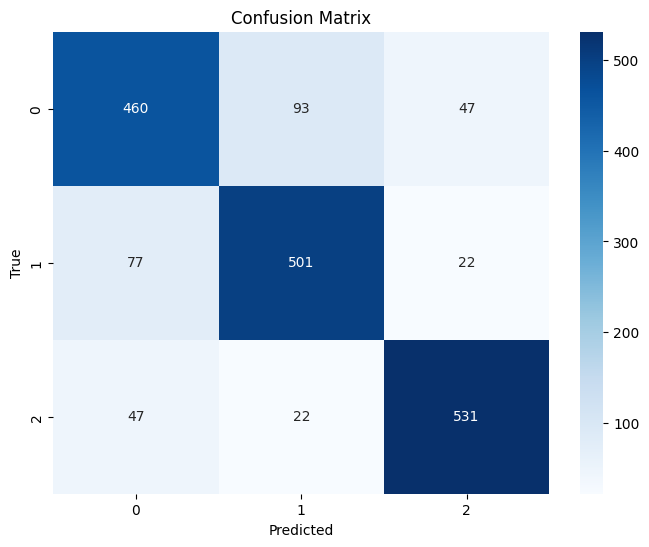

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       600
           1       0.81      0.83      0.82       600
           2       0.89      0.89      0.89       600

    accuracy                           0.83      1800
   macro avg       0.83      0.83      0.83      1800
weighted avg       0.83      0.83      0.83      1800



In [14]:
def evaluate_model_with_confusion_matrix(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Don't need gradients for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predicted labels
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    return cm

best_vgg = best_vgg.to(device)
cm = evaluate_model_with_confusion_matrix(best_vgg, val_loader, device)

In [15]:
# Save the best model's state dictionary
model_save_path = "best_vgg_model.pth"
torch.save(best_vgg.state_dict(), model_save_path)
print(f"Best model saved to {model_save_path}")

from IPython.display import FileLink
# Generate a download link for the model file
FileLink(model_save_path)

Best model saved to best_vgg_model.pth


/kaggle/working/best_vgg_model.pth

### **Test Set Predictions**

In [16]:
label_map = {"cat": 0, "dog": 1, "bird": 2}
reverse_label_map = {v: k for k, v in label_map.items()}  # {0: "cat", 1: "dog", 2: "bird"}

def predict_and_save_to_csv(model, test_loader, device, output_csv="submission.csv"):
    model.eval() 
    model = model.to(device)
    predictions = []
    
    with torch.no_grad(): 
        for images, filenames in tqdm(test_loader): 
            images = images.to(device)
            outputs = model(images) 
            _, preds = torch.max(outputs, dim=1)
            for filename, pred in zip(filenames, preds):
                predictions.append({
                    "filename": filename, 
                    "label": reverse_label_map[pred.item()]  
                })

    df = pd.DataFrame(predictions)
    df = df.sort_values(by="filename", key=lambda col: col.str.extract(r'(\d+)').astype(int).squeeze()).reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    print(f"Submission saved to {output_csv}")

In [17]:
predict_and_save_to_csv(best_vgg, test_loader, device, output_csv="vgg_submission.csv")

100%|██████████| 47/47 [00:14<00:00,  3.26it/s]

Submission saved to vgg_submission.csv


In [18]:
from IPython.display import FileLink
# Generate a download link for the file
file_path = "vgg_submission.csv"
FileLink(file_path)

/kaggle/working/vgg_submission.csv

## **ResNet**

We've only used approach 1 here since it was discovered to be the better choice in the VGG model above. Considering dataset size and problem complexity following three ResNet Model Structures were explored:

- **ResNet-18**
- **ResNet-34**
- **ResNet-50**

We've not tested ResNet-101 and ResNet-152 considering small size of our training set. Plus, we can already see that VGG despite having higher number of parameters didn't necessarilly offer better performance. So the ideal approach for our dataset is to select a model which is deeper but still more efficient in terms of parameter usage.

For ResNet-18, the following hyperparameter configuration was also explored:

- **Learning Rate:** (0.001, 0.0001)
- **Min_lr:** (0.0001, 0.00001)

Again, only the selected configuration is shown to reduce redundancy. The best configuration of lr=0.001 and min_lr= 0.00001 was kept constant for ResNet-34 and ResNet-50. For the final training the number of epochs are limited to 35 epochs as we're only transfer learning for the final layer and so the model should converge early. Also, the above VGG model revealed that 50 epochs are overkill as deeper models seem to converge in 20-35 epochs.

In [5]:
# Defining  & computing mean pixel intensity and std for each channel for normalization

class TrainDataset(Dataset):
    def __init__(self, csv_file, img_dir, device, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.device = device
        self.transform = transform
        self.images = []  # No need to preload images, just store file paths
        self.labels = []  # Store labels
        self.label_map = {"cat": 0, "dog": 1, "bird": 2}
        
        for idx in range(len(self.data)):
            img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
            label = self.label_map[self.data.iloc[idx, 1]]
            self.images.append(img_name)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image.to(self.device)
        label = torch.tensor(label, device=self.device)

        return image, label

class TestDataset(Dataset):
    def __init__(self, img_dir, device, transform=None):
        self.img_dir = img_dir
        self.device = device
        self.transform = transform
        self.images = [] 
        self.image_paths = sorted(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image.to(self.device)

        return image, img_name

labels = pd.read_csv(train_csv_path)['label']
train_indices, val_indices = train_test_split(
    list(range(len(labels))),
    test_size=0.15, 
    stratify=labels,
    random_state=0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tf = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])

train_data = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=tf)
train_sub = Subset(train_data, train_indices)

def compute_mean_std(dataset, device):
    sum_pixels = torch.zeros(3, device=device) 
    sum_squared_pixels = torch.zeros(3, device=device)
    num_pixels = 0

    for idx in tqdm(range(len(dataset))):
        image, _ = dataset[idx]  

        sum_pixels += image.sum(dim=(1, 2))  
        sum_squared_pixels += (image ** 2).sum(dim=(1, 2))  
        num_pixels += image.shape[1] * image.shape[2] 

    mean = sum_pixels / num_pixels
    std = torch.sqrt(sum_squared_pixels / num_pixels - mean ** 2)

    return mean.cpu().numpy(), std.cpu().numpy()

mean, std = compute_mean_std(train_sub, device)
print(f"Training Set Mean: {mean}")
print(f"Training Set Std: {std}")

100%|██████████| 10200/10200 [00:14<00:00, 699.84it/s]

Training Set Mean: [0.4942879  0.4707957  0.41853297]
Training Set Std: [0.24042788 0.23511454 0.245446  ]


In [6]:
# Loading Data w/ Augmentation & Splitting in Train & Validation (Stratified), & Test Set

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                      # Resize images to 224x224
    transforms.RandomRotation(degrees=15),           # Randomly rotate images by up to ±15 degrees
    transforms.RandomHorizontalFlip(),               # Randomly flip images horizontally
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Randomly zoom in on images
    transforms.RandomAffine(degrees=0, shear=10),    # Apply random shear transformations
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),  # Slight distortion for perspective
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5),  # Random color jitter
    transforms.ToTensor(),                           # Convert image to PyTorch tensor and scale to [0, 1]
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize using computed mean & std
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),                   # Resize images to 224x224
    transforms.ToTensor(),                         # Convert images to tensors (scale pixel values to [0, 1])
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize tensors
])

train_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=train_transform)
train_subset = Subset(train_dataset, train_indices)
val_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=test_transform)
val_subset = Subset(val_dataset, val_indices)
test_dataset = TestDataset(img_dir=test_images_dir, device=device, transform=test_transform)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**ResNet-18**

In [7]:
# Load the pretrained ResNet model
resnet = models.resnet18(pretrained=True)

# Freeze all layers except the last one
for param in resnet.parameters():
    param.requires_grad = False

# Modify the classifier layer for 3 classes
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),  # Change input features to match ResNet's final layer size
    nn.ReLU(),                             # ReLU activation
    nn.Dropout(p=0.2),                     # Dropout to prevent overfitting
    nn.Linear(128, 3)                      # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
resnet = nn.DataParallel(resnet)

# Ensure only the last layer's parameters are trainable
for param in resnet.module.fc.parameters():
    param.requires_grad = True

# Move the model to the device
resnet = resnet.to(device)

# Display the model architecture
summary(resnet, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

In [8]:
def train_resnet_and_evaluate(resnet, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5, device='cuda'):
    resnet = resnet.to(device)
    best_model = None
    best_val_loss = float('inf') 

    scaler = GradScaler()

    for epoch in range(num_epochs):
        start_time = time.time() 
        
        # Training
        resnet.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = resnet(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        resnet.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = resnet(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = correct / total

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = resnet.state_dict() 

        epoch_time = time.time() - start_time 
        print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f} ; "
              f"Training Accuracy: {train_accuracy:.4f} ; "
              f"Validation Loss: {avg_val_loss:.4f} ; Validation Accuracy: {val_accuracy:.4f} ; "
              f"Time: {epoch_time:.2f} seconds")
        
        scheduler.step(avg_val_loss)

        torch.cuda.empty_cache()

    resnet.load_state_dict(best_model)
    return resnet

In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.module.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Train, Evaluate, & Return The Best Model
best_resnet = train_resnet_and_evaluate(
    resnet=resnet, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=5, 
    device=device
)

Epoch 1 - Training Loss: 0.7165 ; Training Accuracy: 0.6880 ; Validation Loss: 0.4805 ; Validation Accuracy: 0.8039 ; Time: 78.48 seconds
Epoch 2 - Training Loss: 0.6192 ; Training Accuracy: 0.7375 ; Validation Loss: 0.4543 ; Validation Accuracy: 0.8167 ; Time: 79.25 seconds
Epoch 3 - Training Loss: 0.5923 ; Training Accuracy: 0.7523 ; Validation Loss: 0.4206 ; Validation Accuracy: 0.8289 ; Time: 78.00 seconds
Epoch 4 - Training Loss: 0.5691 ; Training Accuracy: 0.7622 ; Validation Loss: 0.4390 ; Validation Accuracy: 0.8178 ; Time: 79.61 seconds
Epoch 5 - Training Loss: 0.5798 ; Training Accuracy: 0.7577 ; Validation Loss: 0.4117 ; Validation Accuracy: 0.8244 ; Time: 76.78 seconds


**ResNet-34**

In [10]:
# Load the pretrained ResNet model
resnet = models.resnet34(pretrained=True)

# Freeze all layers except the last one
for param in resnet.parameters():
    param.requires_grad = False

# Modify the classifier layer for 3 classes
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),  # Change input features to match ResNet's final layer size
    nn.ReLU(),                             # ReLU activation
    nn.Dropout(p=0.2),                     # Dropout to prevent overfitting
    nn.Linear(128, 3)                      # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
resnet = nn.DataParallel(resnet)

# Ensure only the last layer's parameters are trainable
for param in resnet.module.fc.parameters():
    param.requires_grad = True

# Move the model to the device
resnet = resnet.to(device)

# Display the model architecture
summary(resnet, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
            Conv2d-3         [-1, 64, 112, 112]           9,408
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.module.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Train, Evaluate, & Return The Best Model
best_resnet = train_resnet_and_evaluate(
    resnet=resnet, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=5, 
    device=device
)

Epoch 1 - Training Loss: 0.6775 ; Training Accuracy: 0.7101 ; Validation Loss: 0.4857 ; Validation Accuracy: 0.8044 ; Time: 80.78 seconds
Epoch 2 - Training Loss: 0.6079 ; Training Accuracy: 0.7416 ; Validation Loss: 0.3928 ; Validation Accuracy: 0.8467 ; Time: 80.64 seconds
Epoch 3 - Training Loss: 0.5818 ; Training Accuracy: 0.7565 ; Validation Loss: 0.4000 ; Validation Accuracy: 0.8356 ; Time: 80.25 seconds
Epoch 4 - Training Loss: 0.5734 ; Training Accuracy: 0.7561 ; Validation Loss: 0.3908 ; Validation Accuracy: 0.8406 ; Time: 80.65 seconds
Epoch 5 - Training Loss: 0.5580 ; Training Accuracy: 0.7683 ; Validation Loss: 0.4910 ; Validation Accuracy: 0.7900 ; Time: 80.66 seconds


**ResNet-50**

In [12]:
# Load the pretrained ResNet model
resnet = models.resnet50(pretrained=True)

# Freeze all layers except the last one
for param in resnet.parameters():
    param.requires_grad = False

# Modify the classifier layer for 3 classes
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),  # Change input features to match ResNet's final layer size
    nn.ReLU(),                             # ReLU activation
    nn.Dropout(p=0.2),                     # Dropout to prevent overfitting
    nn.Linear(128, 3)                      # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
resnet = nn.DataParallel(resnet)

# Ensure only the last layer's parameters are trainable
for param in resnet.module.fc.parameters():
    param.requires_grad = True

# Move the model to the device 
resnet = resnet.to(device)

# Display the model architecture
summary(resnet, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]           4,096
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [13]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.module.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Train, Evaluate, & Return The Best Model
best_resnet = train_resnet_and_evaluate(
    resnet=resnet, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=5, 
    device=device
)

Epoch 1 - Training Loss: 0.7879 ; Training Accuracy: 0.6524 ; Validation Loss: 0.4687 ; Validation Accuracy: 0.8094 ; Time: 86.46 seconds
Epoch 2 - Training Loss: 0.6433 ; Training Accuracy: 0.7358 ; Validation Loss: 0.4156 ; Validation Accuracy: 0.8361 ; Time: 86.48 seconds
Epoch 3 - Training Loss: 0.6032 ; Training Accuracy: 0.7474 ; Validation Loss: 0.4250 ; Validation Accuracy: 0.8300 ; Time: 86.64 seconds
Epoch 4 - Training Loss: 0.5861 ; Training Accuracy: 0.7532 ; Validation Loss: 0.3782 ; Validation Accuracy: 0.8400 ; Time: 86.74 seconds
Epoch 5 - Training Loss: 0.5784 ; Training Accuracy: 0.7596 ; Validation Loss: 0.3846 ; Validation Accuracy: 0.8406 ; Time: 86.96 seconds


**Final Training - ResNet - 34**

In [18]:
# Load the pretrained ResNet model
resnet = models.resnet34(pretrained=True)

# Freeze all layers except the last one
for param in resnet.parameters():
    param.requires_grad = False

# Modify the classifier layer for 3 classes
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),  # Change input features to match ResNet's final layer size
    nn.ReLU(),                             # ReLU activation
    nn.Dropout(p=0.2),                     # Dropout to prevent overfitting
    nn.Linear(128, 3)                      # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
resnet = nn.DataParallel(resnet)

# Ensure only the last layer's parameters are trainable
for param in resnet.module.fc.parameters():
    param.requires_grad = True

# Move the model to the device
resnet = resnet.to(device)

In [19]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.module.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Train, Evaluate, & Return The Best Model
best_resnet = train_resnet_and_evaluate(
    resnet=resnet, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=35, 
    device=device
)

Epoch 1 - Training Loss: 0.7054 ; Training Accuracy: 0.6910 ; Validation Loss: 0.4179 ; Validation Accuracy: 0.8378 ; Time: 80.01 seconds
Epoch 2 - Training Loss: 0.5914 ; Training Accuracy: 0.7553 ; Validation Loss: 0.4000 ; Validation Accuracy: 0.8317 ; Time: 79.99 seconds
Epoch 3 - Training Loss: 0.5695 ; Training Accuracy: 0.7674 ; Validation Loss: 0.3767 ; Validation Accuracy: 0.8450 ; Time: 80.95 seconds
Epoch 4 - Training Loss: 0.5581 ; Training Accuracy: 0.7672 ; Validation Loss: 0.3648 ; Validation Accuracy: 0.8489 ; Time: 79.14 seconds
Epoch 5 - Training Loss: 0.5573 ; Training Accuracy: 0.7686 ; Validation Loss: 0.3586 ; Validation Accuracy: 0.8500 ; Time: 79.20 seconds
Epoch 6 - Training Loss: 0.5428 ; Training Accuracy: 0.7688 ; Validation Loss: 0.3397 ; Validation Accuracy: 0.8572 ; Time: 79.90 seconds
Epoch 7 - Training Loss: 0.5365 ; Training Accuracy: 0.7739 ; Validation Loss: 0.3723 ; Validation Accuracy: 0.8444 ; Time: 80.03 seconds
Epoch 8 - Training Loss: 0.5411 ; 

Let's try for 15 more epochs to see if the performance is indeed plateauing around 87-88%!

In [20]:
best_resnet = train_resnet_and_evaluate(
    resnet=best_resnet, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=15, 
    device=device
)

Epoch 1 - Training Loss: 0.4607 ; Training Accuracy: 0.8099 ; Validation Loss: 0.2889 ; Validation Accuracy: 0.8794 ; Time: 80.47 seconds
Epoch 2 - Training Loss: 0.4628 ; Training Accuracy: 0.8089 ; Validation Loss: 0.2953 ; Validation Accuracy: 0.8739 ; Time: 79.95 seconds
Epoch 3 - Training Loss: 0.4682 ; Training Accuracy: 0.8077 ; Validation Loss: 0.2995 ; Validation Accuracy: 0.8711 ; Time: 80.50 seconds
Epoch 4 - Training Loss: 0.4555 ; Training Accuracy: 0.8136 ; Validation Loss: 0.2903 ; Validation Accuracy: 0.8700 ; Time: 79.44 seconds
Epoch 5 - Training Loss: 0.4584 ; Training Accuracy: 0.8101 ; Validation Loss: 0.2852 ; Validation Accuracy: 0.8750 ; Time: 79.10 seconds
Epoch 6 - Training Loss: 0.4645 ; Training Accuracy: 0.8102 ; Validation Loss: 0.2928 ; Validation Accuracy: 0.8744 ; Time: 79.48 seconds
Epoch 7 - Training Loss: 0.4453 ; Training Accuracy: 0.8170 ; Validation Loss: 0.2881 ; Validation Accuracy: 0.8739 ; Time: 79.77 seconds
Epoch 8 - Training Loss: 0.4745 ; 

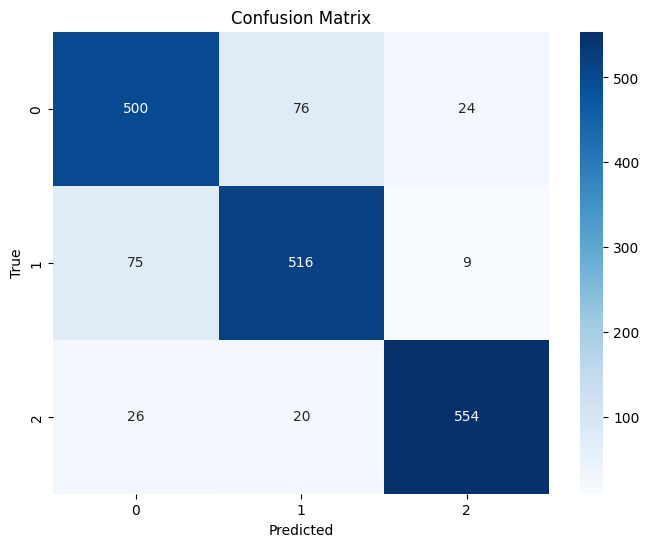

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       600
           1       0.84      0.86      0.85       600
           2       0.94      0.92      0.93       600

    accuracy                           0.87      1800
   macro avg       0.87      0.87      0.87      1800
weighted avg       0.87      0.87      0.87      1800



In [21]:
def evaluate_model_with_confusion_matrix(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Don't need gradients for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)

            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    return cm


best_resnet = best_resnet.to(device)
cm = evaluate_model_with_confusion_matrix(best_resnet, val_loader, device)

In [22]:
# Save the best model's state dictionary
model_save_path = "best_resnet_model.pth"
torch.save(best_resnet.state_dict(), model_save_path)
print(f"Best model saved to {model_save_path}")

from IPython.display import FileLink
# Generate a download link for the model file
FileLink(model_save_path)

Best model saved to best_resnet_model.pth


/kaggle/working/best_resnet_model.pth

### **Test Set Predictions**

In [23]:
label_map = {"cat": 0, "dog": 1, "bird": 2}
reverse_label_map = {v: k for k, v in label_map.items()}  # {0: "cat", 1: "dog", 2: "bird"}

def predict_and_save_to_csv(model, test_loader, device, output_csv="submission.csv"):
    model.eval() 
    model = model.to(device)
    predictions = []
    
    with torch.no_grad(): 
        for images, filenames in tqdm(test_loader): 
            images = images.to(device)
            outputs = model(images) 
            _, preds = torch.max(outputs, dim=1)
            for filename, pred in zip(filenames, preds):
                predictions.append({
                    "filename": filename, 
                    "label": reverse_label_map[pred.item()]  
                })

    df = pd.DataFrame(predictions)
    df = df.sort_values(by="filename", key=lambda col: col.str.extract(r'(\d+)').astype(int).squeeze()).reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    print(f"Submission saved to {output_csv}")

In [24]:
predict_and_save_to_csv(best_resnet, test_loader, device, output_csv="resnet_submission.csv")

100%|██████████| 47/47 [00:06<00:00,  6.78it/s]

Submission saved to resnet_submission.csv


In [25]:
from IPython.display import FileLink
# Generate a download link for the file
file_path = "resnet_submission.csv"
FileLink(file_path)

/kaggle/working/resnet_submission.csv

## **EfficientNet (B4)**

- Lets continue progressing with advance architectures. We could've tested DenseNet at this point but we wanted to see if we could make a significant improvement over ResNet (accuracy >=90%) so we skipped it and directly went to EfficientNet as it offers significantly better performance on ImageNet.

- Also, we have only tested EfficientNet_B4. We've not tested smaller models keeping in view that maximum performance is the aim here and we've also not tested bigger models as we have already seen that increasing the parameters and using even more deeper network beyond a certain point doesn’t work well with our dataset as we previously have opted for ResNet-34 over ResNet-50. EfficientNet_B4 is comparable in size to ResNet-34 in terms of number of parameters but more deeper so a better performance is expected!

- This time we've experimented also with data preprocessing. We've tested if normalizing with mean and std calculated on ImageNet improves accuracy more than normalizing with mean and std calculated on training set.

**Preprocessing based on training set**

In [5]:
# Defining  & computing mean pixel intensity and std for each channel for normalization

class TrainDataset(Dataset):
    def __init__(self, csv_file, img_dir, device, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.device = device
        self.transform = transform
        self.images = []  # No need to preload images, just store file paths
        self.labels = []  # Store labels
        self.label_map = {"cat": 0, "dog": 1, "bird": 2}
        
        for idx in range(len(self.data)):
            img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
            label = self.label_map[self.data.iloc[idx, 1]]
            self.images.append(img_name)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image.to(self.device)
        label = torch.tensor(label, device=self.device)

        return image, label

class TestDataset(Dataset):
    def __init__(self, img_dir, device, transform=None):
        self.img_dir = img_dir
        self.device = device
        self.transform = transform
        self.images = []  # Store image paths
        self.image_paths = sorted(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image.to(self.device)

        return image, img_name

labels = pd.read_csv(train_csv_path)['label']
train_indices, val_indices = train_test_split(
    list(range(len(labels))),
    test_size=0.15, 
    stratify=labels,
    random_state=0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tf = transforms.Compose([transforms.Resize((380, 380)),transforms.ToTensor()])

train_data = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=tf)
train_sub = Subset(train_data, train_indices)

def compute_mean_std(dataset, device):
    sum_pixels = torch.zeros(3, device=device) 
    sum_squared_pixels = torch.zeros(3, device=device)
    num_pixels = 0

    for idx in tqdm(range(len(dataset))):
        image, _ = dataset[idx]  

        sum_pixels += image.sum(dim=(1, 2))  
        sum_squared_pixels += (image ** 2).sum(dim=(1, 2))  
        num_pixels += image.shape[1] * image.shape[2] 

    mean = sum_pixels / num_pixels
    std = torch.sqrt(sum_squared_pixels / num_pixels - mean ** 2)

    return mean.cpu().numpy(), std.cpu().numpy()

mean, std = compute_mean_std(train_sub, device)
print(f"Training Set Mean: {mean}")
print(f"Training Set Std: {std}")

100%|██████████| 10200/10200 [00:26<00:00, 383.43it/s]

Training Set Mean: [0.49430773 0.4708164  0.41855252]
Training Set Std: [0.24033205 0.23501852 0.24535276]


In [6]:
# Loading Data w/ Augmentation & Splitting in Train & Validation (Stratified), & Test Set

train_transform = transforms.Compose([
    transforms.Resize((380, 380)),                      # Resize images to 380x380
    transforms.RandomRotation(degrees=15),           # Randomly rotate images by up to ±15 degrees
    transforms.RandomHorizontalFlip(),               # Randomly flip images horizontally
    transforms.RandomResizedCrop(size=380, scale=(0.8, 1.0)),  # Randomly zoom in on images
    transforms.RandomAffine(degrees=0, shear=10),    # Apply random shear transformations
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),  # Slight distortion for perspective
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5),  # Random color jitter
    transforms.ToTensor(),                           # Convert image to PyTorch tensor and scale to [0, 1]
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize using computed mean & std
])

test_transform = transforms.Compose([
    transforms.Resize((380, 380)),                   # Resize images to 380x380
    transforms.ToTensor(),                         # Convert images to tensors (scale pixel values to [0, 1])
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize tensors
])

train_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=train_transform)
train_subset = Subset(train_dataset, train_indices)
val_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=test_transform)
val_subset = Subset(val_dataset, val_indices)
test_dataset = TestDataset(img_dir=test_images_dir, device=device, transform=test_transform)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Load the pretrained EfficientNet-B4 model
efficientnet_b4 = models.efficientnet_b4(pretrained=True)

# Freeze all layers except the last one
for param in efficientnet_b4.parameters():
    param.requires_grad = False

# Modify the classifier layer for 3 classes
efficientnet_b4.classifier = nn.Sequential(
    nn.Linear(efficientnet_b4.classifier[1].in_features, 128),  # Change input features
    nn.ReLU(),                                    # ReLU activation
    nn.Dropout(p=0.2),                            # Dropout layer
    nn.Linear(128, 3)                             # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
efficientnet_b4 = nn.DataParallel(efficientnet_b4)

# Ensure only the last layer's parameters are trainable
for param in efficientnet_b4.module.classifier.parameters():
    param.requires_grad = True

# Move the model to the device
efficientnet_b4 = efficientnet_b4.to(device)

# Display the model architecture
summary(efficientnet_b4, input_size=(3, 380, 380))

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 222MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 190, 190]           1,296
            Conv2d-2         [-1, 48, 190, 190]           1,296
       BatchNorm2d-3         [-1, 48, 190, 190]              96
       BatchNorm2d-4         [-1, 48, 190, 190]              96
              SiLU-5         [-1, 48, 190, 190]               0
              SiLU-6         [-1, 48, 190, 190]               0
            Conv2d-7         [-1, 48, 190, 190]             432
       BatchNorm2d-8         [-1, 48, 190, 190]              96
              SiLU-9         [-1, 48, 190, 190]               0
           Conv2d-10         [-1, 48, 190, 190]             432
      BatchNorm2d-11         [-1, 48, 190, 190]              96
             SiLU-12         [-1, 48, 190, 190]               0
AdaptiveAvgPool2d-13             [-1, 48, 1, 1]               0
AdaptiveAvgPool2d-14             [-1, 4

In [8]:
def train_efficientnet_and_evaluate(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5, device='cuda'):
    model = model.to(device)
    best_model = None
    best_val_loss = float('inf')  

    scaler = GradScaler()

    for epoch in range(num_epochs):
        start_time = time.time()  
        
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = correct / total

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()  

        epoch_time = time.time() - start_time 
        print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f} ; "
              f"Training Accuracy: {train_accuracy:.4f} ; "
              f"Validation Loss: {avg_val_loss:.4f} ; Validation Accuracy: {val_accuracy:.4f} ; "
              f"Time: {epoch_time:.2f} seconds")
        
        scheduler.step(avg_val_loss)

        torch.cuda.empty_cache()

    model.load_state_dict(best_model)
    return model

In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_b4.module.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Train, Evaluate, & Return The Best Model
best_efficientnet_b4 = train_efficientnet_and_evaluate(
    model=efficientnet_b4, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=5, 
    device=device
)

Epoch 1 - Training Loss: 0.6701 ; Training Accuracy: 0.7209 ; Validation Loss: 0.4379 ; Validation Accuracy: 0.8356 ; Time: 210.96 seconds
Epoch 2 - Training Loss: 0.5590 ; Training Accuracy: 0.7665 ; Validation Loss: 0.4046 ; Validation Accuracy: 0.8417 ; Time: 213.44 seconds
Epoch 3 - Training Loss: 0.5386 ; Training Accuracy: 0.7755 ; Validation Loss: 0.3865 ; Validation Accuracy: 0.8550 ; Time: 211.48 seconds
Epoch 4 - Training Loss: 0.5241 ; Training Accuracy: 0.7820 ; Validation Loss: 0.3706 ; Validation Accuracy: 0.8594 ; Time: 211.29 seconds
Epoch 5 - Training Loss: 0.5204 ; Training Accuracy: 0.7805 ; Validation Loss: 0.3709 ; Validation Accuracy: 0.8561 ; Time: 209.51 seconds


**Preprocessing based on ImageNet dataset**

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(400),                                # Resize the shortest side to 400px (slightly larger than 380x380)
    transforms.RandomRotation(degrees=15),                # Randomly rotate images by up to ±15 degrees
    transforms.RandomHorizontalFlip(),                    # Randomly flip images horizontally
    transforms.RandomResizedCrop(size=380, scale=(0.8, 1.0)), # Random crop to 380x380
    transforms.RandomAffine(degrees=0, shear=10),         # Apply random shear transformations
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5), # Slight distortion for perspective
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5), # Random color jitter
    transforms.CenterCrop(380),                           # Crop to 380x380
    transforms.ToTensor(),                                # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean & std
])

test_transform = transforms.Compose([
    transforms.Resize(400),                               # Resize the shortest side to 400px
    transforms.CenterCrop(380),                           # Crop to 380x380
    transforms.ToTensor(),                                # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean & std
])

train_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=train_transform)
train_subset = Subset(train_dataset, train_indices)
val_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=test_transform)
val_subset = Subset(val_dataset, val_indices)
test_dataset = TestDataset(img_dir=test_images_dir, device=device, transform=test_transform)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# Load the pretrained EfficientNet-B4 model
efficientnet_b4 = models.efficientnet_b4(pretrained=True)

# Freeze all layers except the last one
for param in efficientnet_b4.parameters():
    param.requires_grad = False

# Modify the classifier layer for 3 classes
efficientnet_b4.classifier = nn.Sequential(
    nn.Linear(efficientnet_b4.classifier[1].in_features, 128),  # Change input features
    nn.ReLU(),                                    # ReLU activation
    nn.Dropout(p=0.2),                            # Dropout layer
    nn.Linear(128, 3)                             # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
efficientnet_b4 = nn.DataParallel(efficientnet_b4)

# Ensure only the last layer's parameters are trainable
for param in efficientnet_b4.module.classifier.parameters():
    param.requires_grad = True

# Move the model to the device
efficientnet_b4 = efficientnet_b4.to(device)

In [12]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_b4.module.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=0.00001, verbose=True)

# Train, Evaluate, & Return The Best Model
best_efficientnet_b4 = train_efficientnet_and_evaluate(
    model=efficientnet_b4, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=5, 
    device=device
)

Epoch 1 - Training Loss: 0.6774 ; Training Accuracy: 0.7150 ; Validation Loss: 0.4454 ; Validation Accuracy: 0.8339 ; Time: 216.16 seconds
Epoch 2 - Training Loss: 0.5431 ; Training Accuracy: 0.7732 ; Validation Loss: 0.4135 ; Validation Accuracy: 0.8389 ; Time: 214.03 seconds
Epoch 3 - Training Loss: 0.5296 ; Training Accuracy: 0.7830 ; Validation Loss: 0.3888 ; Validation Accuracy: 0.8417 ; Time: 215.15 seconds
Epoch 4 - Training Loss: 0.5246 ; Training Accuracy: 0.7814 ; Validation Loss: 0.3880 ; Validation Accuracy: 0.8456 ; Time: 216.24 seconds
Epoch 5 - Training Loss: 0.5186 ; Training Accuracy: 0.7794 ; Validation Loss: 0.3873 ; Validation Accuracy: 0.8439 ; Time: 215.52 seconds


- Training-set normalization seems to result in slightly better validation accuracy. ImageNet normalization works reasonably well too, with a comparable performance in terms of training loss and accuracy. Both approaches are effective, but the training-set normalization might be better for our specific dataset, as it leads to slightly better and more consistent validation performance.

**Final Training - Efficient_B4 w/ Training-set Normalization**

- Initially we tried with lr=0.001, min_lr=0.00001, and factor=0.5. While this configuration was good for the early stages of training but after 20 epochs model started to oscillate around 85% validation accuracy. So, we changed the min_lr to 1e-6 and reduced factor to 0.3 to allow finer adjustments during late training with more gradual reductions in lr.

In [13]:
# Loading Data w/ Augmentation & Splitting in Train & Validation (Stratified), & Test Set

train_transform = transforms.Compose([
    transforms.Resize((380, 380)),                      # Resize images to 380x380
    transforms.RandomRotation(degrees=15),           # Randomly rotate images by up to ±15 degrees
    transforms.RandomHorizontalFlip(),               # Randomly flip images horizontally
    transforms.RandomResizedCrop(size=380, scale=(0.8, 1.0)),  # Randomly zoom in on images
    transforms.RandomAffine(degrees=0, shear=10),    # Apply random shear transformations
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),  # Slight distortion for perspective
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5),  # Random color jitter
    transforms.ToTensor(),                           # Convert image to PyTorch tensor and scale to [0, 1]
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize using computed mean & std
])

test_transform = transforms.Compose([
    transforms.Resize((380, 380)),                   # Resize images to 380x380
    transforms.ToTensor(),                         # Convert images to tensors (scale pixel values to [0, 1])
    transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])  # Normalize tensors
])

train_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=train_transform)
train_subset = Subset(train_dataset, train_indices)
val_dataset = TrainDataset(csv_file=train_csv_path, img_dir=train_images_dir, device=device, transform=test_transform)
val_subset = Subset(val_dataset, val_indices)
test_dataset = TestDataset(img_dir=test_images_dir, device=device, transform=test_transform)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
# Load the pretrained EfficientNet-B4 model
efficientnet_b4 = models.efficientnet_b4(pretrained=True)

# Freeze all layers except the last one
for param in efficientnet_b4.parameters():
    param.requires_grad = False

# Modify the classifier layer for 3 classes
efficientnet_b4.classifier = nn.Sequential(
    nn.Linear(efficientnet_b4.classifier[1].in_features, 128),  # Change input features
    nn.ReLU(),                                    # ReLU activation
    nn.Dropout(p=0.2),                            # Dropout layer
    nn.Linear(128, 3)                             # Output layer with 3 classes
)

# Wrap the model in DataParallel (for using multiple GPUs-Kaggle)
efficientnet_b4 = nn.DataParallel(efficientnet_b4)

# Ensure only the last layer's parameters are trainable
for param in efficientnet_b4.module.classifier.parameters():
    param.requires_grad = True

# Move the model to the device
efficientnet_b4 = efficientnet_b4.to(device)

In [15]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_b4.module.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.3, min_lr=0.000001, verbose=True)

# Train, Evaluate, & Return The Best Model
best_efficientnet_b4 = train_efficientnet_and_evaluate(
    model=efficientnet_b4, 
    train_loader=train_loader, 
    test_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=50, 
    device=device
)

Epoch 1 - Training Loss: 0.6677 ; Training Accuracy: 0.7200 ; Validation Loss: 0.4232 ; Validation Accuracy: 0.8406 ; Time: 211.17 seconds
Epoch 2 - Training Loss: 0.5598 ; Training Accuracy: 0.7648 ; Validation Loss: 0.4002 ; Validation Accuracy: 0.8539 ; Time: 211.22 seconds
Epoch 3 - Training Loss: 0.5368 ; Training Accuracy: 0.7779 ; Validation Loss: 0.3705 ; Validation Accuracy: 0.8650 ; Time: 210.98 seconds
Epoch 4 - Training Loss: 0.5152 ; Training Accuracy: 0.7792 ; Validation Loss: 0.3662 ; Validation Accuracy: 0.8539 ; Time: 212.19 seconds
Epoch 5 - Training Loss: 0.5175 ; Training Accuracy: 0.7837 ; Validation Loss: 0.3617 ; Validation Accuracy: 0.8561 ; Time: 211.44 seconds
Epoch 6 - Training Loss: 0.5032 ; Training Accuracy: 0.7895 ; Validation Loss: 0.3558 ; Validation Accuracy: 0.8572 ; Time: 211.56 seconds
Epoch 7 - Training Loss: 0.4888 ; Training Accuracy: 0.7931 ; Validation Loss: 0.3623 ; Validation Accuracy: 0.8600 ; Time: 211.67 seconds
Epoch 8 - Training Loss: 0.

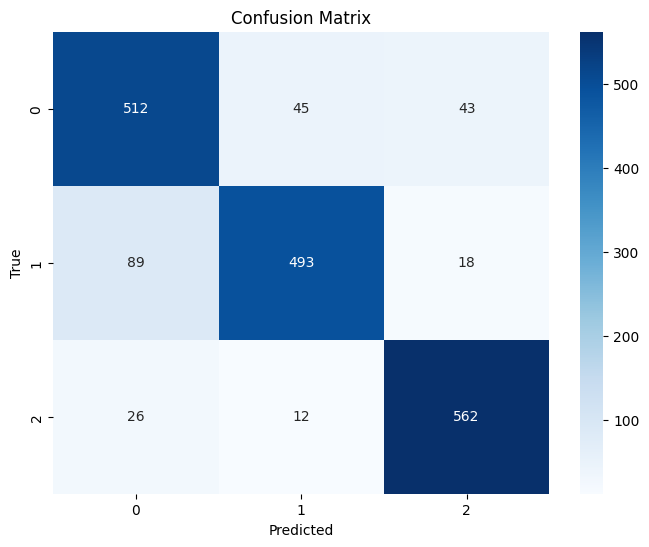

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       600
           1       0.90      0.82      0.86       600
           2       0.90      0.94      0.92       600

    accuracy                           0.87      1800
   macro avg       0.87      0.87      0.87      1800
weighted avg       0.87      0.87      0.87      1800



In [16]:
def evaluate_model_with_confusion_matrix(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Don't need gradients for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    return cm


best_efficientnet_b4 = best_efficientnet_b4.to(device)
cm = evaluate_model_with_confusion_matrix(best_efficientnet_b4, val_loader, device)

- If we compare the classification report to that of ResNet-34, there are minor differences in the regard that EfficientNet-B4 is more balanced w.r.t classes but overall, the performance is almost same as ResNet-34. This is contrary to our expectations as we expected the EfficientNet-B4 to have overall validation accuracy between 90% to 95%.

- This result is again confirmed by identical performance of ResNet-34 and EfficientNet-B4 on the test set (Check test set scores of each approach at the end!)

In [17]:
# Save the best model's state dictionary
model_save_path = "best_efficientnet_model.pth"
torch.save(best_efficientnet_b4.state_dict(), model_save_path)
print(f"Best model saved to {model_save_path}")

from IPython.display import FileLink
# Generate a download link for the model file
FileLink(model_save_path)

Best model saved to best_efficientnet_model.pth


/kaggle/working/best_efficientnet_model.pth

### **Test Set Predictions**

In [18]:
label_map = {"cat": 0, "dog": 1, "bird": 2}
reverse_label_map = {v: k for k, v in label_map.items()}  # {0: "cat", 1: "dog", 2: "bird"}

def predict_and_save_to_csv(model, test_loader, device, output_csv="submission.csv"):
    model.eval() 
    model = model.to(device)
    predictions = []
    
    with torch.no_grad(): 
        for images, filenames in tqdm(test_loader): 
            images = images.to(device)
            outputs = model(images) 
            _, preds = torch.max(outputs, dim=1)
            for filename, pred in zip(filenames, preds):
                predictions.append({
                    "filename": filename, 
                    "label": reverse_label_map[pred.item()]  
                })

    df = pd.DataFrame(predictions)
    df = df.sort_values(by="filename", key=lambda col: col.str.extract(r'(\d+)').astype(int).squeeze()).reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    print(f"Submission saved to {output_csv}")

In [19]:
predict_and_save_to_csv(best_efficientnet_b4, test_loader, device, output_csv="efficientnet_submission.csv")

100%|██████████| 47/47 [00:24<00:00,  1.89it/s]

Submission saved to efficientnet_submission.csv


In [20]:
from IPython.display import FileLink
# Generate a download link for the file
file_path = "efficientnet_submission.csv"
FileLink(file_path)

/kaggle/working/efficientnet_submission.csv

## **Test Set Scores**

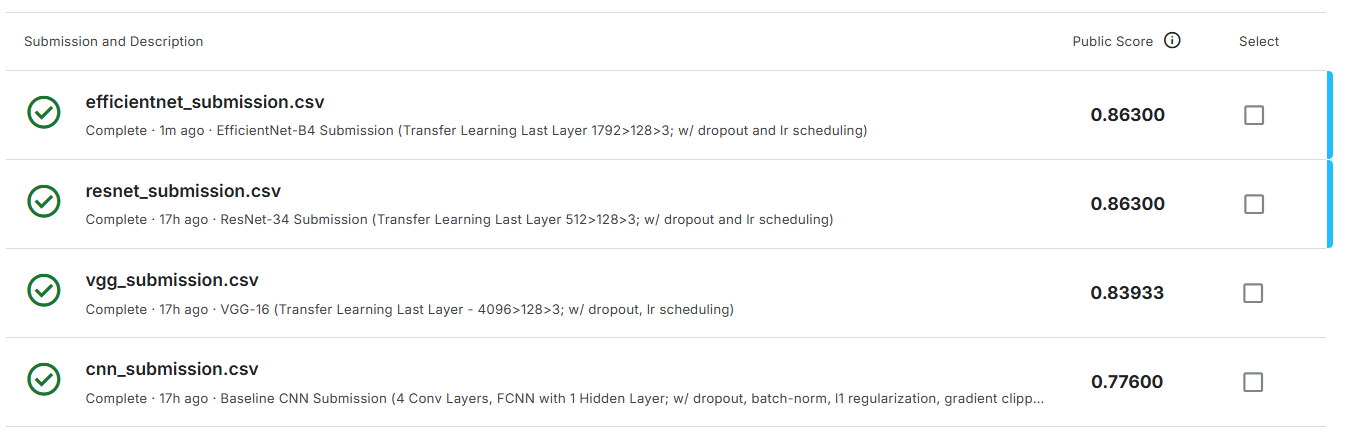